Fehler C_X 0.10226287158826769
CX=  0.772727272727273
Fehler nu_gr 54.1022773673549
nu_gr=  1061.03295394597


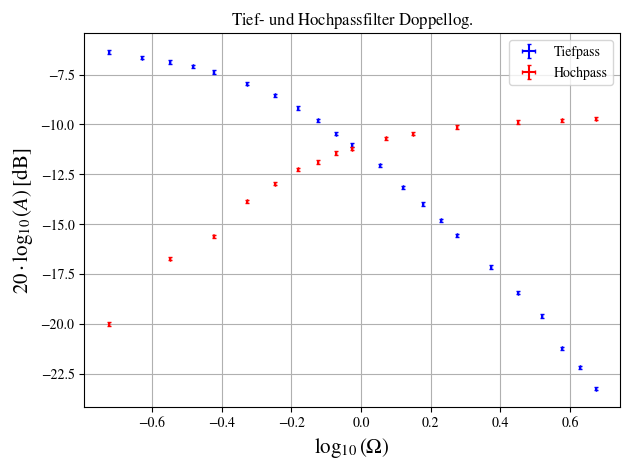

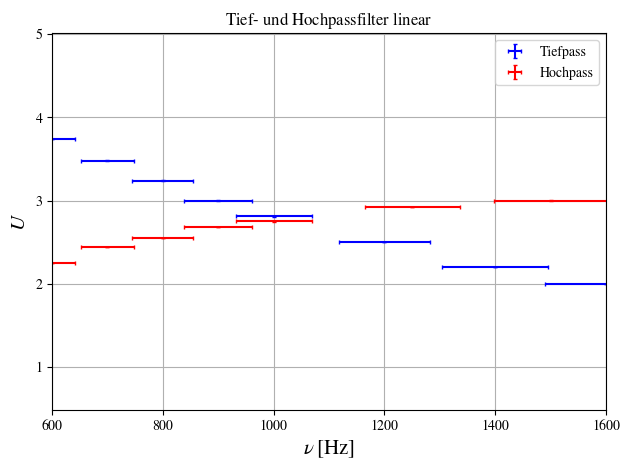

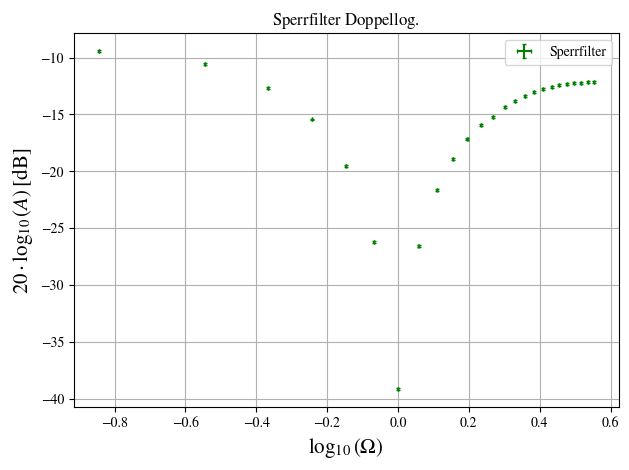

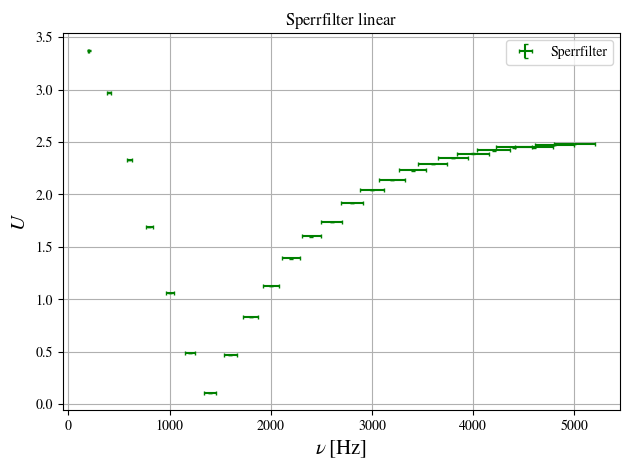

Q_theo Fehler:  0.1149586915722776
Fehler L (c)=  1.7925369651944205e-05
L=  1000.00000000000
0.00143
U_E=  0.17062109793869443
xval=  0.0014279985806725229    yval=  7.563103593932263e-05
xval=  0.05646616424827199    yval=  0.02028724464009771
xval=  0.030545314061877313    yval=  0.005289970591721766
xval=  0.019881617238148686    yval=  0.002172854342967065
xval=  0.013959650535151334    yval=  0.0010621473233267292
xval=  0.009985422732775086    yval=  0.0005397525801500045
xval=  0.007992530561788683    yval=  0.00034562294321248096
xval=  0.005996846899233374    yval=  0.00019449233186702835
xval=  0.004998194411283109    yval=  0.00013436006481943845
xval=  0.003999075358286335    yval=  8.600162060830766e-05
xval=  0.0029996098575963987    yval=  4.8380804154780215e-05
xval=  2.3023359823970242e-17    yval=  0.0


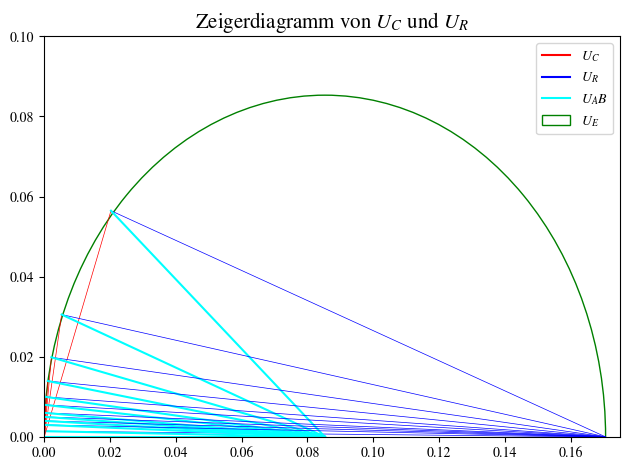

U_AB=  0.07268300827396959


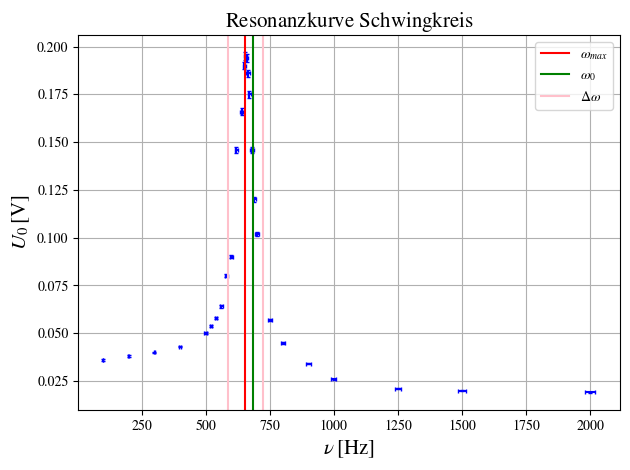

w_0 Fehler =  30.42903097250923
Q1 Fehler =  0.13788582233137678
Q2 Fehler =  0.004702275342541205
Q3 Fehler =  0.4297415208442687


In [2]:
import sympy as sp
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'



def calcErr(f: sp.Expr, values: List[float], errorL: List[float]) -> Tuple[sp.Function, float]:
    """
    Calculate error using Gaussian error propagation.
    
    Parameters:
    -----------
    f : sympy.Expr
        Symbolic function for which error needs to be calculated
    values : List[float]
        List of values for each variable in the function
    errorL : List[float]
        List of uncertainties for each variable in the function
        
    Returns:
    --------
    Tuple[sp.Function, float]
        - Symbolic error propagation function
        - Numerical result of error calculation
    """
    # Get variables in the function
    vars = list(f.free_symbols)
    
    if not (len(vars) == len(errorL) == len(values)):
        raise ValueError("Number of values and errors must match number of variables in function")
    
    # Create symbolic error variables
    error_symbols = [sp.Symbol(f'Δ{var}') for var in vars]
    
    # Create symbolic error propagation function
    error_expr = sp.sqrt(sum((sp.diff(f, var) * err)**2 
                           for var, err in zip(vars, error_symbols)))
    # Convert to sp.Function
    error_func = sp.Function('σ')(*error_symbols)
    
    error_func = error_func.subs(error_func, error_expr)
    
    # Print the symbolic error propagation function
    # print("\nSymbolic error propagation function:")
    # print(f"{error_func.simplify()}")
    
    # Calculate numerical result using the provided values
    numerical_error = error_expr.subs(dict(zip(error_symbols, errorL)))
    result = float(numerical_error.evalf(subs=dict(zip(vars, values))))
    
    return result

def find_error_func(f: sp.Expr) -> sp.Function:
    """
    Creates symbolic error propagation function for given function f.
    
    Parameters:
    -----------
    f : sympy.Expr
        Symbolic function for which error propagation function is needed
        
    Returns:
    --------
    sp.Function
        Symbolic error propagation function
    """
    # Get variables in the function
    vars = list(f.free_symbols)
    
    # Create symbolic error variables
    error_symbols = [sp.Symbol(f'Δ{var}') for var in vars]
    
    # Create symbolic error propagation function
    error_expr = sp.sqrt(sum((sp.diff(f, var) * err)**2 
                           for var, err in zip(vars, error_symbols)))
    
    # Convert to sp.Function
    error_func = sp.Function('σ')(*error_symbols)
    error_func = error_func.subs(error_func, error_expr)
    
    return error_func

def b():
    
    L1, R2, RB, R1, RA = sp.symbols('L_1 R_2 R_B R_1 R_A')
    values = [20, 40, 1000, 32, 20]
    errors = [0.001, 0.002, 0.03, 0.0234, 0.01235]
    
    L2 = L1 * (R2 - RB) / (R1 + RA)
    return calcErr(L2, values, errors)

def c():
    U_RL, nu, I, R = sp.symbols('U_RL nu I R')
    values = [1.112, 1000, 0.067, 1.6]
    errors = [0.01 * values[0], 1, 0.01 * values[2], 0.1]
    L = (sp.sqrt((U_RL**2) * ((R * I)**2)) / (2*sp.pi*nu*I))
    find_error_func(L).simplify()
    print("Fehler L (c)= " , calcErr(L, values, errors))
    print("L= ", nu.evalf(subs={U_RL:values[0], nu:values[1], I:values[2], R:values[3]}))

def d():
    source = "Data/234d.csv"
    data = np.genfromtxt(source, delimiter=' ')
    
    dataU = data[:,1:]
    print(dataU[0][1])
    fig, ax = plt.subplots()

    U_E = np.sqrt((dataU[:,0].mean()**2)+(dataU[:,1].mean()**2))
    U_AB = 0
    print("U_E= ", U_E)
    for i in (dataU):
        sinphi = (i[1]/np.sqrt(i[0]**2 + i[1]**2))
        yval = sinphi * i[1]
        theta = np.pi - np.arcsin(sinphi)
        xval = np.sin(theta) * i[0]
        gamma = np.pi - theta - np.arcsin(sinphi)

        print("xval= ", xval, "   yval= ", yval)
        plt.plot([0,yval], [0, xval], color='red', linewidth=0.5)
        plt.plot([U_E, yval], [0, xval], color='blue', linewidth=0.5)
        plt.plot([U_E/2, yval], [0, xval], color='cyan')
        U_AB+= np.sqrt((U_E/2 - xval)**2+(yval)**2)
        
    plt.plot(0,0, color='red', label=r'$U_C$')
    plt.plot(0,0, color='blue', label=r'$U_R$')
    plt.plot(0,0, color='cyan', label=r'$U_AB$')
    circle1 = plt.Circle((U_E/2, 0), U_E/2, color='green', fill=False, label=r'$U_E$')
    ax.add_patch(circle1)
    plt.xlim(0, 0.175)
    plt.ylim(0, 0.1)
    plt.autoscale(False)
    plt.legend()
    plt.title(r"$\text{Zeigerdiagramm von } U_C \text{ und } U_R$", fontsize=15)
    plt.tight_layout()
    plt.savefig('Figures/Zeigerdiag.png', dpi=1200)
    plt.show()
    print("U_AB= ", U_AB/len(dataU[:,1]))
def plot(source, target, xlabel, ylabel):

    data = np.genfromtxt(source, delimiter=' ')
    plt.grid()
    plt.scatter(data[:,0], data[:, 1], marker="+")
    
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.tight_layout()

def plotlog(source, target, xlabel, ylabel, logs):

    data = np.genfromtxt(source, delimiter=' ')
    plt.grid()
    if(logs == 2):
        plt.scatter(np.log10(data[:,0]), np.log10(data[:, 1]), marker="+")
        
    if(logs == 1):
        plt.scatter((data[:,0]), np.log10(data[:, 1]), marker="+")
        
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.tight_layout()

def j():
    source = "Data/234j.csv"
    f, U = sp.symbols('f U')
    data = np.genfromtxt(source, delimiter=' ')
    values = [data[:,0], data[:,1]]
    xerrors = 0.01 * data[:,0]
    yerrors = 0.01 * data[:,1] / 1000
    
    w_max = 4116

    plt.errorbar(data[:,0], data[:,1] / 1000, yerr=yerrors, xerr=xerrors, ls='none', capsize=1.5, ecolor='blue')
    plt.xlabel(r'$\nu \: \left[ \text{Hz} \right]$', fontsize=15)
    plt.ylabel(r'$U_0 \: \left[ \text{V} \right]$', fontsize=15)
    plt.grid()
    plt.axvline(x=4116/(2*np.pi) + 70, color='pink')

    plt.axvline(x=4116/(2*np.pi), color='red', label=r'$\omega_{max}$')
    plt.axvline(x=4303/(2*np.pi), color='green', label=r'$\omega_{0}$')
    plt.axvline(x=4116/(2*np.pi) - 70, color='pink', label=r'$\Delta \omega$')

    plt.title(r'$\text{Resonanzkurve Schwingkreis}$', fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.savefig('Figures/Resonanzkurve.png', dpi=1200)
    plt.show()

    L, C = sp.symbols(' L C')
    values = [36e-3, 1.5e-6]
    errors = [values[0] * 0.01, values[1] * 0.01]

    w = 1/sp.sqrt(L*C)

    print("w_0 Fehler = ", calcErr(w, values, errors))
    find_error_func(w)

    U1, U2 = sp.symbols('U1 U2')
    values = [195, 20]
    errors = [values[0] * 0.01, values[1] * 0.01]

    Q1 = U1/U2

    print("Q1 Fehler = ", calcErr(Q1, values, errors))

    w0, dw = sp.symbols('w0 dw')
    values = [4303, 440]
    errors = [30, 20]

    Q2 = w0/dw

    print("Q2 Fehler = ", calcErr(Q2, values, errors))

    w0, L, RL = sp.symbols('w0 L RL')
    values = [4303, 39e-3, 9.5]
    errors = [30, values[1]*0.01, 0.2]

    Q3 = w0 * L / RL

    print("Q3 Fehler = ", calcErr(Q3, values, errors))

def f():
    data_tief = np.genfromtxt("Data/234f_tief.csv", delimiter=' ')
    data_hoch = np.genfromtxt("Data/234f_hoch.csv", delimiter=' ')
    data_sperr = np.genfromtxt("Data/234f_sperr.csv", delimiter=' ')
    
    R = 100
    C = 1.5e-6
    U_E = 10
    nu_gr_val = 1 / (2*np.pi * R*C)
    nu_sperr = 1400

    R, C = sp.symbols('R C')
    nu = 1 / (2*np.pi * R *C)
    values = [100, 1.5e-6]
    errors = [0.05 * values[0], 0.01 * values[1]]
    find_error_func(nu).simplify()
    print("Fehler nu_gr" , calcErr(nu, values, errors))
    l = calcErr(nu, values, errors)
    print("nu_gr= ", nu.evalf(subs={R:values[0], C:values[1]}))

    nu_gr_er = nu.evalf(subs={R:values[0], C:values[1]})

    freq = sp.symbols('f')
    Omega_func = freq / nu_gr_val

    values = data_tief[:,0]
    errors = 0.01 * data_tief[:,0]
    
    Omega_tief_err = np.sqrt((values*l / nu_gr_val**2)**2 + (nu_gr_val * errors /  nu_gr_val**2)**2)

    values = data_hoch[:,0]
    errors = 0.01 * values
    Omega_hoch_err = np.sqrt((values*l / nu_gr_val**2)**2 + (nu_gr_val * errors /  nu_gr_val**2)**2)

    nu_0 = 1400

    values = data_sperr[:,0]
    errors = 0.01 * values
    Omega_sperr_err = np.sqrt((values*l / nu_0**2)**2 + (nu_0 * errors /  nu_0**2)**2)


    Omega_tief = data_tief[:,0] / nu_gr_val
    Omega_hoch = data_hoch[:,0] / nu_gr_val
    Omega_sperr = data_sperr[:,0] / nu_sperr

    A_tief = data_tief[:,1] / U_E
    A_hoch = data_hoch[:,1] / U_E
    A_sperr = data_sperr[:,1] / U_E

    A_tief_err = (1/U_E) * data_tief[:,1] * 0.01
    A_hoch_err = (1/U_E) * data_hoch[:,1] * 0.01
    A_sperr_err = (1/U_E) * data_sperr[:,1] * 0.01 

    plt.errorbar(np.log10(Omega_tief), 20*np.log10(A_tief), xerr=(Omega_tief_err/(nu_gr_val * np.log(10) * Omega_tief)), yerr=(20*A_tief_err/(np.log(10)*A_tief)), ls='', capsize=1.5, ecolor='blue', label='Tiefpass')
    plt.errorbar(np.log10(Omega_hoch), 20*np.log10(A_hoch), xerr=(Omega_hoch_err/(nu_gr_val * np.log(10) * Omega_hoch)), ls='', yerr=(20*A_hoch_err/(np.log(10) * A_hoch)), capsize=1.5, ecolor='red', label="Hochpass")
    plt.legend()
    plt.xlabel(r'$\log_{10} (\Omega)$', fontsize=15)
    plt.ylabel(r'$20 \cdot \log_{10} (A) \: \left[ \text{dB} \right]$', fontsize=15)
    plt.grid()
    plt.title(r'$\text{Tief- und Hochpassfilter Doppellog.}$')
    plt.tight_layout()
    plt.savefig('Figures/TiefHochLog.png', dpi=1200)
    plt.show()

    plt.errorbar((Omega_tief*nu_gr_val), (A_tief)*U_E, xerr=(Omega_tief_err)*nu_0, yerr=(A_tief_err), ls='', capsize=1.5, ecolor='blue', label='Tiefpass')
    plt.errorbar((Omega_hoch*nu_gr_val), (A_hoch)*U_E, xerr=(Omega_hoch_err)*nu_0, ls='', yerr=(A_hoch_err), capsize=1.5, ecolor='red', label='Hochpass')
    plt.legend()
    plt.xlabel(r'$\nu \: \left[ \text{Hz} \right]$', fontsize=15)
    plt.ylabel(r'$U$', fontsize=15)
    plt.xlim(600, 1600)
    plt.title(r'$\text{Tief- und Hochpassfilter linear}$')
    plt.grid()
    plt.tight_layout()
    plt.savefig('Figures/TiefHochLin.png', dpi=1200)
    plt.show()

    plt.errorbar(np.log10(Omega_sperr), 20*np.log10(A_sperr), xerr=(Omega_sperr_err/(nu_0* np.log(10) * Omega_sperr)), yerr=(20*A_sperr_err/(np.log(10)*A_sperr)), ls='', capsize=1.5, label="Sperrfilter", ecolor='green')
    plt.legend()
    plt.xlabel(r'$\log_{10} (\Omega)$', fontsize=15)
    plt.ylabel(r'$20 \cdot \log_{10} (A) \: \left[ \text{dB} \right]$', fontsize=15)
    plt.grid()
    plt.title(r'$\text{Sperrfilter Doppellog.}$')
    plt.tight_layout()
    plt.savefig('Figures/SperrLog.png', dpi=1200)
    plt.show()

    plt.errorbar((Omega_sperr)*nu_0, (A_sperr)*U_E, xerr=(Omega_sperr_err)*nu_0, yerr=(A_sperr_err), ls='', capsize=1.5, label="Sperrfilter", ecolor='green')
    plt.legend()
    plt.xlabel(r'$\nu \: \left[ \text{Hz} \right]$', fontsize=15)
    plt.ylabel(r'$U$', fontsize=15)
    plt.grid()
    plt.title(r'$\text{Sperrfilter linear}$')
    plt.tight_layout()
    plt.savefig('Figures/SperrLog.png', dpi=1200)
    plt.show()

    R, C, w0 = sp.symbols('R C w0')
    Q_theo = 1 / (w0 * R *C)
    values = [100, 1.5e-6, 2*np.pi*1400]
    errors = [0.05 * values[0], 0.01 * values[1], 200*2*np.pi]
    find_error_func(Q_theo).simplify()
    print("Q_theo Fehler: ", calcErr(Q_theo, values, errors))

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


def a():
    RX, RY, C1 = sp.symbols('R_X R_Y C_1')
    CX = C1 * RX / RY
    values = [0.34 * 200, 0.66 * 200, 1.5]
    errors = [0.04 * 200, 0.04 * 200, 0]
    find_error_func(CX).simplify()
    print("Fehler C_X" , calcErr(CX, values, errors))
    print("CX= ", CX.evalf(subs={RX:values[0], RY:values[1], C1:values[2]}))

def b():
    L1, R1, R2 = sp.symbols('L_1 R_X R_Y')
    LX = L1 * R2/R1
    values = [4.74, 0.375 * 200, 0.525 * 200]
    errors = [0.02 * values[0], 0.04 * 200, 0.04 * 200]
    return find_error_func(LX)
    print("Fehler L_X" , calcErr(LX, values, errors))
    print("LX= " , LX.evalf(subs={L1:values[0], R1:values[1], R2:values[2]}))



a()
b()
f()
c()
d()
j()